# Imports

In [60]:
import pandas as pd
import numpy as np
from math import floor
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn import set_config

from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler #undersampler
from imblearn.under_sampling import TomekLinks # undersampler

from imblearn.ensemble import BalancedRandomForestClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import warnings
warnings.filterwarnings("ignore")

# EDA

In [61]:
def calculate_vif(data):
    data = data.select_dtypes(include=[np.number])
    # Adding a constant column for intercept
    data = add_constant(data)
    vif = pd.DataFrame()
    vif["variables"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif

# Preprocessing

## Engineer features

In [62]:
class FeaturePreprocessor:
    def __init__(self,raw):
        self.data = raw.copy()
        self.cols_to_delete = []

    @staticmethod
    def bmi_groupping(bmi):
        if bmi < 18.5 :
            return 0
        elif bmi >= 18.5 and bmi <= 24.9:
            return 1
        elif bmi >= 25 and bmi <= 29.9 :
            return 2
        elif bmi >= 30 and bmi <= 34.9 :
            return 3
        elif bmi >= 35 and bmi <= 39.9 :
            return 4
        else:
            return 5

    @staticmethod
    def general_health_groupping(gh):
        if gh==0 or gh==1:
            return 0
        elif gh==2 or gh==3:
            return 1
        else:
            return 2

    @staticmethod
    def bmi_age_groupping(row):
        bmi = row['bmi']
        age_group = row['age_group']
        if bmi >= 30 and age_group >= 3:
            return 2
        elif bmi >= 25 and age_group >= 3:
            return 1
        return 0

    def age_health(self):
        self.data['age_health'] = self.data['age_group'].astype(str) + "_" + self.data['general_health'].astype(str)
        self.cols_to_delete.extend(['age_group','general_health'])

    def FeaturePreprocessorPipeline(self):
        # drop highly correlated features
        self.data.drop(columns=['height','weight'], inplace=True)

        # drop columns related with diabetics
        self.data.drop(columns=['prediabetes','currently_insulin', 'blood_sugar',
                                'hemoglobin', 'eye_exam', 'eye_photo',
                                'diabetes_education'], inplace=True)

        # drop previous bmi groups, create new
        self.data.drop(columns=['bmi_groups'], inplace=True)
        self.data['bmi_groups'] = self.data['bmi'].apply(FeaturePreprocessor.bmi_groupping)

        # change general health categorization
        self.data['general_health'] = self.data['general_health'].apply(FeaturePreprocessor.general_health_groupping)
        # create bmi-age feature
        self.data['bmi_age'] = self.data.apply(FeaturePreprocessor.bmi_age_groupping, axis=1)
        self.data['bmi_age'] = self.data['bmi_age'].astype('category')
        # create bmi-exercise feature
        self.data['bmi_exercise'] = self.data['bmi_groups'].astype(str) + "_" + self.data['exercise_lately'].astype(str)
        self.cols_to_delete.extend(['exercise_lately'])
        self.data['bmi_exercise'] = self.data['bmi_exercise'].astype('category')
        # create smoking alcohol feature
        self.data['smoking_alcohol'] = self.data['smoking'].astype(str) + "_" + self.data['heavy_drinker'].astype(str)
        self.cols_to_delete.extend(['smoking','heavy_drinker'])
        self.data['smoking_alcohol'] = self.data['smoking_alcohol'].astype('category')
        # create education income feature
        self.data['education_income'] = self.data['education'].astype(str) + "_" + self.data['income_group'].astype(str)
        self.cols_to_delete.extend(['education','income_group'])
        self.data['education_income'] = self.data['education_income'].astype('category')
        # create insurance-healthcare feature
        self.data['insurance_healthcare'] = self.data['has_insurance'].astype(str) + "_" + \
                                            self.data['affords_doctor'].astype(str) + "_" +\
                                            self.data['has_doctor'].astype(str)
        self.cols_to_delete.extend(['has_insurance','affords_doctor','has_doctor'])
        self.data['insurance_healthcare'] = self.data['insurance_healthcare'].astype('category')
        # group health problems
        self.data['health_problems'] =  self.data['stroke'].astype(str) + "_" + \
                                        self.data['depression'].astype(str) + "_" +\
                                        self.data['asthma_history'].astype(str)
        self.cols_to_delete.extend(['stroke','depression','asthma_history'])
        self.data['health_problems'] = self.data['health_problems'].astype('category')
        self.data.drop(columns=self.cols_to_delete, inplace=True)


##  Label Preprocessor

In [63]:
class LabelPreprocessor():
    def __init__(self, inp, info):
        self.data = inp.copy()
        self.info = info
        self.label_name = self.info['label']
        self.numerical_features = ['bmi']
        self.categorical_features = list(set(self.data.columns) - set(self.numerical_features) - set([self.label_name]))

    def convert_type(self):
        for col in self.categorical_features:
            self.data[col] = self.data[col].astype('category')

    def extract_labels(self, train=False):
        if train:
            self.train_labels = self.train_data[[self.label_name]].to_numpy().flatten()
        else:
            self.labels = self.data[[self.label_name]].to_numpy().flatten()

    def remove_labels(self):
        self.data.drop([self.label_name], axis=1, inplace=True)

    @staticmethod
    def binary_labels(labels):
        labels[labels == 2] = 1
        return labels

    def LabelPreprocessorPipeline(self):
        self.extract_labels()
        if self.info['binary_classification']:
            self.labels = self.binary_labels(self.labels)
        self.remove_labels()

## ModelPreprocessor

In [64]:
class ModelPreprocessor():
    def __init__(self, inp, info):
        self.__dict__ = inp.__dict__.copy()
        self.info = info
        self.random_state = self.info['random_state']

    def split(self, stratify=True):
        stratify_labels = self.labels if stratify else None
        self.train_data, self.test_data, self.train_labels, self.test_labels = train_test_split(
            self.data,
            self.labels,
            test_size=self.info['test_size'],
            random_state=self.random_state,
            stratify=stratify_labels
        )

    @staticmethod
    def class_frequencies(data, labels):
        _ , class_samples = np.unique(labels, return_counts=True)
        class_freq = class_samples/len(data)
        return class_freq

    def run_smote(self):
        smote = SMOTE(random_state=self.random_state)
        self.train_data, self.train_labels = smote.fit_resample(self.train_data, self.train_labels)

    def run_undersampling(self):
        sampling_strategy = {
          0: floor(len(self.train_labels[self.train_labels == 0]) / 3*0.75),
          1: floor(len(self.train_labels[self.train_labels == 1])*0.75),
          2: floor(len(self.train_labels[self.train_labels == 2])*0.75)
          }
        undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state = self.random_state)
        self.train_data, self.train_labels = undersampler.fit_resample(self.train_data, self.train_labels)

    def run_oversampling(self):
        sampling_strategy = {
            0:len(self.train_labels[self.train_labels==0]),
            1:len(self.train_labels[self.train_labels==2]),
            2:len(self.train_labels[self.train_labels==2])
        }
        oversampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state = self.random_state)
        self.train_data, self.train_labels = oversampler.fit_resample(self.train_data, self.train_labels)

    def run_equal_sampling(self):
        labels_series = pd.Series(self.train_labels, name=self.label_name)
        min_class_size  = labels_series.value_counts().min()

        # Sample from each class
        np.random.seed(self.random_state)
        balanced_indices = []
        for label in np.unique(self.train_labels):
            # Find indices of each class label
            class_indices = labels_series[labels_series == label].index
            # Sample indices of this class
            sampled_indices = np.random.choice(class_indices, size=min_class_size, replace=False)
            balanced_indices.extend(sampled_indices)

        # Use the sampled indices to select rows from train_data
        self.train_data = self.train_data.iloc[balanced_indices]
        self.train_labels = self.train_labels[balanced_indices]

    def run_rare_class_sampling(self):
        class_freq = self.class_frequencies(self.train_data, self.train_labels)
        T = self.info['RCS']['T']
        num_samples = self.info['RCS']['num_samples']
        probs = np.exp((1 - class_freq) / T)
        probs /= probs.sum()
        probs_to_labels = {}
        for i in range(len(probs)):
            probs_to_labels[i] = probs[i]
        sample_weights = pd.Series(self.train_labels).map(probs_to_labels)

        np.random.seed(self.random_state)
        sampled_indices = np.random.choice(
            a=len(self.train_labels),
            size=num_samples,
            replace=False,
            p=sample_weights / sample_weights.sum()
        )

        # Subset the train_data and train_labels using the sampled indices
        self.train_data = self.train_data.iloc[sampled_indices]
        self.train_labels = self.train_labels[sampled_indices]

    def shuffle_data(self):
        np.random.seed(self.random_state)
        shuffle_indices = np.random.permutation(len(self.train_data))
        self.train_data = self.train_data.iloc[shuffle_indices].reset_index(drop=True)
        self.train_labels = self.train_labels[shuffle_indices]

    def data_balancing(self):
        # RESAMPLE MUST BE DONE ONLY ON TRAIN DATA
        if self.info['balancing_method']==None:
            pass

        # ---SMOTE---
        if self.info['balancing_method']=='smote':
            self.run_smote()

        # ---UNDERSAMPLING----
        if self.info['balancing_method']=='undersampling':
            self.run_undersampling()

        # ---EQUAL NUMBER OF LABELS PER CLASS---
        if self.info['balancing_method']=='equal':
            self.run_equal_sampling()
#             self.shuffle_data()

        # ---RARE CLASS SAMPLING---
        if self.info['balancing_method']=='RCS':
            self.run_rare_class_sampling()

    def apply_transformations(self, datatype):
        if datatype=='train':
            if self.info['apply_scaler']:
                self.scaler = StandardScaler()
                self.train_data[self.numerical_features] = self.scaler.fit_transform(self.train_data[self.numerical_features])
        elif datatype=='test':
            if self.info['apply_scaler']:
                self.test_data[self.numerical_features] = self.scaler.transform(self.test_data[self.numerical_features])

    def ModelPreprocessorPipeline(self):
        self.split()
        self.data_balancing()
        self.shuffle_data()
        self.apply_transformations(datatype='train')
        self.apply_transformations(datatype='test')


# Classifiers

## Base Class

In [65]:
class BaseClassifier:
    def __init__(self, data_object, random_state=42):
        self.random_state = random_state
        self.model = None
        self.data = data_object

    def model_pipeline(self, report=False, fi=False, cm=False):
        self.create_model()
        self.train()
        if report:
            self.generate_classification_report()
#             self.class_accuracy()
        if fi and hasattr(self, 'feature_importance'):
            self.feature_importance()
        if cm:
            self.plot_confusion_matrix()

    def create_model(self):
        raise NotImplementedError("This method should be overridden by subclasses")

    def train(self):
        print("calling training")
        if self.model is not None:
            self.model.fit(self.data.train_data, self.data.train_labels)
        else:
          print("model is None ")

    def generate_classification_report(self):
#         if self.model is not None:
        predictions = self.model.predict(self.data.test_data)
        print(classification_report(self.data.test_labels, predictions))

    def plot_confusion_matrix(self):
#         if self.model is not None:
        y_pred = self.model.predict(self.data.test_data)
        cm = confusion_matrix(self.data.test_labels, y_pred, normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

    def class_accuracy(self):
        predictions = self.model.predict(self.data.test_data)
        classes = np.unique(self.data.test_labels)
        accuracy = {}
        for cls in classes:
            cls_mask = (self.data.test_labels == cls)
            cls_acc = np.mean(predictions[cls_mask] == self.data.test_labels[cls_mask])
            accuracy[cls] = cls_acc
        print("Class-wise Accuracy:", accuracy)



## RandomForest

In [66]:
class RandomForestModel(BaseClassifier):
    def __init__(self, data_object, random_state=42):
        super().__init__(data_object, random_state)
        self.name = 'RandomForest'

    def create_model(self):
        self.model = RandomForestClassifier(n_estimators = 100,
                                            random_state=self.random_state,
                                            verbose=0,
                                            n_jobs=-1,
                                            class_weight='balanced',
                                            bootstrap=False
                                           )

    def feature_importance(self):
        if self.model is not None:
            importance = self.model.feature_importances_
            features = self.data.train_data.columns

            indices = np.argsort(importance)
            sorted_importance = np.take(importance, indices, axis=0)
            sorted_features = np.take(features, indices, axis=0)

            plt.figure(figsize=(5,5))
            plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
            plt.yticks(range(len(sorted_importance)), sorted_features)
            plt.xlabel('Feature Importance')
            plt.ylabel('Feature')
            plt.show()

## BalancedRandomForest

In [67]:
class BalancedRandomForestModel(BaseClassifier):
    def __init__(self, data_object, random_state=42):
        super().__init__(data_object, random_state)
        self.name = 'BalancedRandomForest'

    def create_model(self):
        self.model = BalancedRandomForestClassifier(
                                                    n_estimators = 200,
                                                    random_state=self.random_state,
                                                    verbose=0,
                                                    n_jobs=-1,
#                                                     max_features = None,
                                                    oob_score = True
#                                                     class_weight='balanced'
                                                   )
    def feature_importance(self):
        if self.model is not None:
            importance = self.model.feature_importances_
            features = self.data.train_data.columns

            indices = np.argsort(importance)
            sorted_importance = np.take(importance, indices, axis=0)
            sorted_features = np.take(features, indices, axis=0)

            plt.figure(figsize=(5,5))
            plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
            plt.yticks(range(len(sorted_importance)), sorted_features)
            plt.xlabel('Feature Importance')
            plt.ylabel('Feature')
            plt.show()

# Main

## read csv

In [68]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/Othercomputers/My Laptop/ΕΔΕΜΜ/EARINO/BIODEDOMENA/BioDataProject/ΤΕΛΙΚΟ ΠΑΡΑΔΟΤΕΟ/Data/'

set_config(transform_output = 'pandas')
inputs = pd.read_csv(path + 'diabetes_dataset_total.csv')
inputs.columns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Index(['sex', 'age_group', 'education', 'has_insurance', 'income_group',
       'race', 'marital_status', 'general_health', 'exercise_lately',
       'sleep_time', 'smoking', 'heavy_drinker', 'height', 'weight', 'bmi',
       'bmi_groups', 'has_doctor', 'affords_doctor', 'last_checkup',
       'asthma_history', 'stroke', 'depression', 'blood_sugar', 'prediabetes',
       'currently_insulin', 'hemoglobin', 'eye_exam', 'eye_photo',
       'diabetes_education', 'diabetes'],
      dtype='object')

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## InfoTable

In [70]:
info = {
    'label':'diabetes',
    'binary_classification':True,
    'random_state':42,
    'test_size':0.1,
    'RCS': {
        'T': 0.1,
        'num_samples': 100000,
    },
    'apply_scaler':True,
}

## Execution 1: No data balancing and Random Forest

In [71]:
info['balancing_method'] = 'None'

### Preprocessing

In [72]:
data = FeaturePreprocessor(inputs)
data.FeaturePreprocessorPipeline()
data.data

,sex,age_group,race,marital_status,general_health,sleep_time,bmi,last_checkup,diabetes,bmi_groups,bmi_age,bmi_exercise,smoking_alcohol,education_income,insurance_healthcare,health_problems
0,1,4,0,1,0,5,16.60,3,2,0,0,0_1,0_0,3_0,0_1_2,0_1_1
1,0,5,0,3,1,8,26.58,1,2,2,1,2_1,2_0,1_2,1_0_0,0_0_1
2,1,2,0,1,0,8,23.71,0,0,1,0,1_1,3_0,3_3,1_0_0,0_0_0
3,1,5,0,0,1,4,21.63,0,0,1,0,1_1,3_0,3_4,1_0_0,0_0_1
4,1,5,0,2,1,9,31.64,0,2,3,2,3_0,2_0,2_1,1_0_0,0_0_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247593,1,5,6,0,1,6,24.56,0,1,1,0,1_1,3_0,0_0,1_1_0,0_0_0
247594,1,4,6,0,2,5,26.57,0,1,2,1,2_0,3_0,2_2,1_0_0,0_1_0
247595,0,5,6,1,1,7,21.79,3,1,1,0,1_0,0_0,2_1,1_0_2,0_0_0
247596,1,1,6,4,1,6,20.78,1,1,1,0,1_1,3_0,2_0,1_0_0,0_0_0


In [73]:
data = LabelPreprocessor(data.data, info)
data.LabelPreprocessorPipeline()
data.data

,sex,age_group,race,marital_status,general_health,sleep_time,bmi,last_checkup,bmi_groups,bmi_age,bmi_exercise,smoking_alcohol,education_income,insurance_healthcare,health_problems
0,1,4,0,1,0,5,16.60,3,0,0,0_1,0_0,3_0,0_1_2,0_1_1
1,0,5,0,3,1,8,26.58,1,2,1,2_1,2_0,1_2,1_0_0,0_0_1
2,1,2,0,1,0,8,23.71,0,1,0,1_1,3_0,3_3,1_0_0,0_0_0
3,1,5,0,0,1,4,21.63,0,1,0,1_1,3_0,3_4,1_0_0,0_0_1
4,1,5,0,2,1,9,31.64,0,3,2,3_0,2_0,2_1,1_0_0,0_0_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247593,1,5,6,0,1,6,24.56,0,1,0,1_1,3_0,0_0,1_1_0,0_0_0
247594,1,4,6,0,2,5,26.57,0,2,1,2_0,3_0,2_2,1_0_0,0_1_0
247595,0,5,6,1,1,7,21.79,3,1,0,1_0,0_0,2_1,1_0_2,0_0_0
247596,1,1,6,4,1,6,20.78,1,1,0,1_1,3_0,2_0,1_0_0,0_0_0


In [74]:
data = ModelPreprocessor(data, info)
data.ModelPreprocessorPipeline()
data.data

,sex,age_group,race,marital_status,general_health,sleep_time,bmi,last_checkup,bmi_groups,bmi_age,bmi_exercise,smoking_alcohol,education_income,insurance_healthcare,health_problems
0,1,4,0,1,0,5,16.60,3,0,0,0_1,0_0,3_0,0_1_2,0_1_1
1,0,5,0,3,1,8,26.58,1,2,1,2_1,2_0,1_2,1_0_0,0_0_1
2,1,2,0,1,0,8,23.71,0,1,0,1_1,3_0,3_3,1_0_0,0_0_0
3,1,5,0,0,1,4,21.63,0,1,0,1_1,3_0,3_4,1_0_0,0_0_1
4,1,5,0,2,1,9,31.64,0,3,2,3_0,2_0,2_1,1_0_0,0_0_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247593,1,5,6,0,1,6,24.56,0,1,0,1_1,3_0,0_0,1_1_0,0_0_0
247594,1,4,6,0,2,5,26.57,0,2,1,2_0,3_0,2_2,1_0_0,0_1_0
247595,0,5,6,1,1,7,21.79,3,1,0,1_0,0_0,2_1,1_0_2,0_0_0
247596,1,1,6,4,1,6,20.78,1,1,0,1_1,3_0,2_0,1_0_0,0_0_0


In [75]:
len(data.labels), len(data.train_labels), len(data.test_labels)

(247598, 222838, 24760)

In [76]:
np.unique(data.train_labels, return_counts=True), np.unique(data.test_labels, return_counts=True)

((array([0, 1]), array([180021,  42817])),
 (array([0, 1]), array([20003,  4757])))

In [77]:
vif_data = calculate_vif(data.data)
vif_data

,variables,VIF
0,const,82.350461
1,sex,1.014452
2,age_group,1.253272
3,race,1.050590
4,marital_status,1.141492
5,general_health,1.096910
6,sleep_time,1.017641
7,bmi,5.559474
8,last_checkup,1.074213
9,bmi_groups,5.518516


### Classification

calling training
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     20003
           1       0.55      0.38      0.45      4757

    accuracy                           0.82     24760
   macro avg       0.70      0.65      0.67     24760
weighted avg       0.80      0.82      0.81     24760



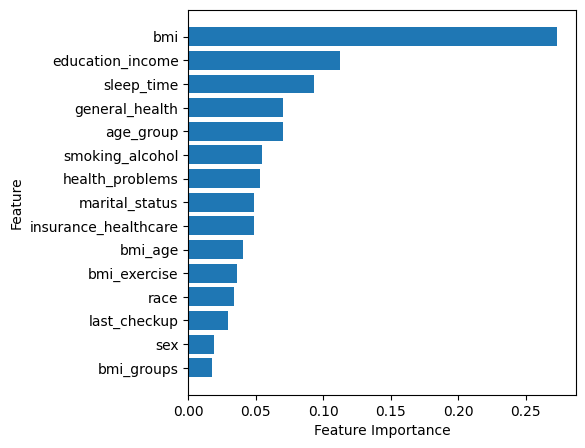

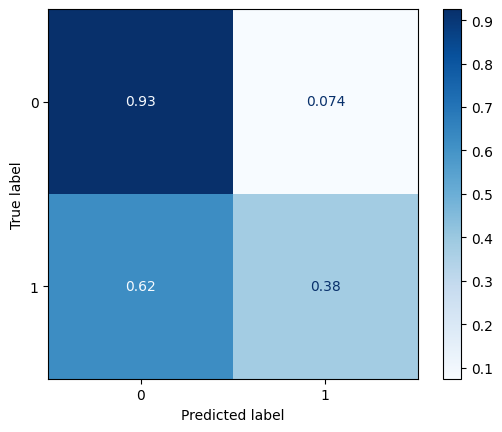

CPU times: user 1min 21s, sys: 659 ms, total: 1min 22s
Wall time: 51.3 s


In [78]:
%%time
ex1 = RandomForestModel(data)
ex1.model_pipeline(report=True, fi=True, cm=True)

## Execution 2: Using data balancing and Random Forest

In [79]:
info['balancing_method'] = 'RCS'

### Preprocessing

In [80]:
data = FeaturePreprocessor(inputs)
data.FeaturePreprocessorPipeline()
data.data

,sex,age_group,race,marital_status,general_health,sleep_time,bmi,last_checkup,diabetes,bmi_groups,bmi_age,bmi_exercise,smoking_alcohol,education_income,insurance_healthcare,health_problems
0,1,4,0,1,0,5,16.60,3,2,0,0,0_1,0_0,3_0,0_1_2,0_1_1
1,0,5,0,3,1,8,26.58,1,2,2,1,2_1,2_0,1_2,1_0_0,0_0_1
2,1,2,0,1,0,8,23.71,0,0,1,0,1_1,3_0,3_3,1_0_0,0_0_0
3,1,5,0,0,1,4,21.63,0,0,1,0,1_1,3_0,3_4,1_0_0,0_0_1
4,1,5,0,2,1,9,31.64,0,2,3,2,3_0,2_0,2_1,1_0_0,0_0_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247593,1,5,6,0,1,6,24.56,0,1,1,0,1_1,3_0,0_0,1_1_0,0_0_0
247594,1,4,6,0,2,5,26.57,0,1,2,1,2_0,3_0,2_2,1_0_0,0_1_0
247595,0,5,6,1,1,7,21.79,3,1,1,0,1_0,0_0,2_1,1_0_2,0_0_0
247596,1,1,6,4,1,6,20.78,1,1,1,0,1_1,3_0,2_0,1_0_0,0_0_0


In [81]:
data = LabelPreprocessor(data.data, info)
data.LabelPreprocessorPipeline()
data.data

,sex,age_group,race,marital_status,general_health,sleep_time,bmi,last_checkup,bmi_groups,bmi_age,bmi_exercise,smoking_alcohol,education_income,insurance_healthcare,health_problems
0,1,4,0,1,0,5,16.60,3,0,0,0_1,0_0,3_0,0_1_2,0_1_1
1,0,5,0,3,1,8,26.58,1,2,1,2_1,2_0,1_2,1_0_0,0_0_1
2,1,2,0,1,0,8,23.71,0,1,0,1_1,3_0,3_3,1_0_0,0_0_0
3,1,5,0,0,1,4,21.63,0,1,0,1_1,3_0,3_4,1_0_0,0_0_1
4,1,5,0,2,1,9,31.64,0,3,2,3_0,2_0,2_1,1_0_0,0_0_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247593,1,5,6,0,1,6,24.56,0,1,0,1_1,3_0,0_0,1_1_0,0_0_0
247594,1,4,6,0,2,5,26.57,0,2,1,2_0,3_0,2_2,1_0_0,0_1_0
247595,0,5,6,1,1,7,21.79,3,1,0,1_0,0_0,2_1,1_0_2,0_0_0
247596,1,1,6,4,1,6,20.78,1,1,0,1_1,3_0,2_0,1_0_0,0_0_0


In [82]:
data = ModelPreprocessor(data, info)
data.ModelPreprocessorPipeline()
data.data

,sex,age_group,race,marital_status,general_health,sleep_time,bmi,last_checkup,bmi_groups,bmi_age,bmi_exercise,smoking_alcohol,education_income,insurance_healthcare,health_problems
0,1,4,0,1,0,5,16.60,3,0,0,0_1,0_0,3_0,0_1_2,0_1_1
1,0,5,0,3,1,8,26.58,1,2,1,2_1,2_0,1_2,1_0_0,0_0_1
2,1,2,0,1,0,8,23.71,0,1,0,1_1,3_0,3_3,1_0_0,0_0_0
3,1,5,0,0,1,4,21.63,0,1,0,1_1,3_0,3_4,1_0_0,0_0_1
4,1,5,0,2,1,9,31.64,0,3,2,3_0,2_0,2_1,1_0_0,0_0_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247593,1,5,6,0,1,6,24.56,0,1,0,1_1,3_0,0_0,1_1_0,0_0_0
247594,1,4,6,0,2,5,26.57,0,2,1,2_0,3_0,2_2,1_0_0,0_1_0
247595,0,5,6,1,1,7,21.79,3,1,0,1_0,0_0,2_1,1_0_2,0_0_0
247596,1,1,6,4,1,6,20.78,1,1,0,1_1,3_0,2_0,1_0_0,0_0_0


In [83]:
len(data.labels), len(data.train_labels), len(data.test_labels)

(247598, 100000, 24760)

In [84]:
np.unique(data.train_labels, return_counts=True), np.unique(data.test_labels, return_counts=True)

((array([0, 1]), array([57183, 42817])),
 (array([0, 1]), array([20003,  4757])))

In [85]:
vif_data = calculate_vif(data.data)
vif_data

,variables,VIF
0,const,82.350461
1,sex,1.014452
2,age_group,1.253272
3,race,1.050590
4,marital_status,1.141492
5,general_health,1.096910
6,sleep_time,1.017641
7,bmi,5.559474
8,last_checkup,1.074213
9,bmi_groups,5.518516


### Classification

calling training
              precision    recall  f1-score   support

           0       0.91      0.75      0.82     20003
           1       0.40      0.69      0.51      4757

    accuracy                           0.74     24760
   macro avg       0.66      0.72      0.67     24760
weighted avg       0.81      0.74      0.76     24760



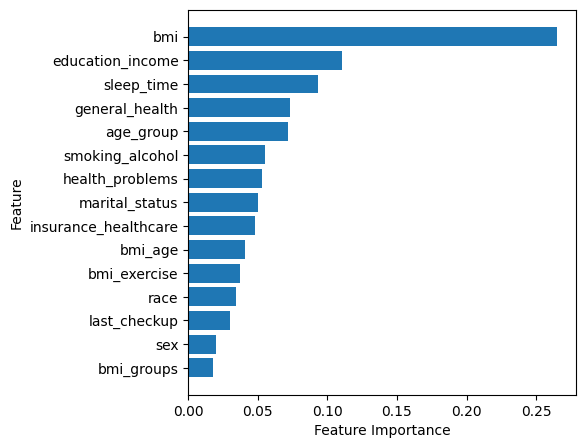

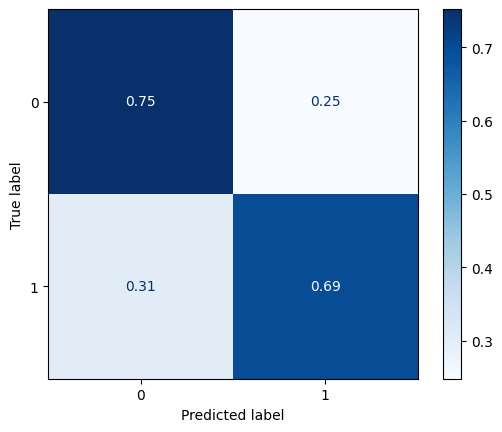

CPU times: user 36 s, sys: 316 ms, total: 36.3 s
Wall time: 25.4 s


In [86]:
%%time
ex2 = RandomForestModel(data)
ex2.model_pipeline(report=True, fi=True, cm=True)

## Execution 3: No data balancing and Balanced Random Forest

In [87]:
info['balancing_method'] = 'None'

### Preprocessing

In [88]:
data = FeaturePreprocessor(inputs)
data.FeaturePreprocessorPipeline()
data.data

,sex,age_group,race,marital_status,general_health,sleep_time,bmi,last_checkup,diabetes,bmi_groups,bmi_age,bmi_exercise,smoking_alcohol,education_income,insurance_healthcare,health_problems
0,1,4,0,1,0,5,16.60,3,2,0,0,0_1,0_0,3_0,0_1_2,0_1_1
1,0,5,0,3,1,8,26.58,1,2,2,1,2_1,2_0,1_2,1_0_0,0_0_1
2,1,2,0,1,0,8,23.71,0,0,1,0,1_1,3_0,3_3,1_0_0,0_0_0
3,1,5,0,0,1,4,21.63,0,0,1,0,1_1,3_0,3_4,1_0_0,0_0_1
4,1,5,0,2,1,9,31.64,0,2,3,2,3_0,2_0,2_1,1_0_0,0_0_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247593,1,5,6,0,1,6,24.56,0,1,1,0,1_1,3_0,0_0,1_1_0,0_0_0
247594,1,4,6,0,2,5,26.57,0,1,2,1,2_0,3_0,2_2,1_0_0,0_1_0
247595,0,5,6,1,1,7,21.79,3,1,1,0,1_0,0_0,2_1,1_0_2,0_0_0
247596,1,1,6,4,1,6,20.78,1,1,1,0,1_1,3_0,2_0,1_0_0,0_0_0


In [89]:
data = LabelPreprocessor(data.data, info)
data.LabelPreprocessorPipeline()
data.data

,sex,age_group,race,marital_status,general_health,sleep_time,bmi,last_checkup,bmi_groups,bmi_age,bmi_exercise,smoking_alcohol,education_income,insurance_healthcare,health_problems
0,1,4,0,1,0,5,16.60,3,0,0,0_1,0_0,3_0,0_1_2,0_1_1
1,0,5,0,3,1,8,26.58,1,2,1,2_1,2_0,1_2,1_0_0,0_0_1
2,1,2,0,1,0,8,23.71,0,1,0,1_1,3_0,3_3,1_0_0,0_0_0
3,1,5,0,0,1,4,21.63,0,1,0,1_1,3_0,3_4,1_0_0,0_0_1
4,1,5,0,2,1,9,31.64,0,3,2,3_0,2_0,2_1,1_0_0,0_0_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247593,1,5,6,0,1,6,24.56,0,1,0,1_1,3_0,0_0,1_1_0,0_0_0
247594,1,4,6,0,2,5,26.57,0,2,1,2_0,3_0,2_2,1_0_0,0_1_0
247595,0,5,6,1,1,7,21.79,3,1,0,1_0,0_0,2_1,1_0_2,0_0_0
247596,1,1,6,4,1,6,20.78,1,1,0,1_1,3_0,2_0,1_0_0,0_0_0


In [90]:
data = ModelPreprocessor(data, info)
data.ModelPreprocessorPipeline()
data.data

,sex,age_group,race,marital_status,general_health,sleep_time,bmi,last_checkup,bmi_groups,bmi_age,bmi_exercise,smoking_alcohol,education_income,insurance_healthcare,health_problems
0,1,4,0,1,0,5,16.60,3,0,0,0_1,0_0,3_0,0_1_2,0_1_1
1,0,5,0,3,1,8,26.58,1,2,1,2_1,2_0,1_2,1_0_0,0_0_1
2,1,2,0,1,0,8,23.71,0,1,0,1_1,3_0,3_3,1_0_0,0_0_0
3,1,5,0,0,1,4,21.63,0,1,0,1_1,3_0,3_4,1_0_0,0_0_1
4,1,5,0,2,1,9,31.64,0,3,2,3_0,2_0,2_1,1_0_0,0_0_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247593,1,5,6,0,1,6,24.56,0,1,0,1_1,3_0,0_0,1_1_0,0_0_0
247594,1,4,6,0,2,5,26.57,0,2,1,2_0,3_0,2_2,1_0_0,0_1_0
247595,0,5,6,1,1,7,21.79,3,1,0,1_0,0_0,2_1,1_0_2,0_0_0
247596,1,1,6,4,1,6,20.78,1,1,0,1_1,3_0,2_0,1_0_0,0_0_0


In [91]:
len(data.labels), len(data.train_labels), len(data.test_labels)

(247598, 222838, 24760)

In [92]:
np.unique(data.train_labels, return_counts=True), np.unique(data.test_labels, return_counts=True)

((array([0, 1]), array([180021,  42817])),
 (array([0, 1]), array([20003,  4757])))

In [93]:
vif_data = calculate_vif(data.data)
vif_data

,variables,VIF
0,const,82.350461
1,sex,1.014452
2,age_group,1.253272
3,race,1.050590
4,marital_status,1.141492
5,general_health,1.096910
6,sleep_time,1.017641
7,bmi,5.559474
8,last_checkup,1.074213
9,bmi_groups,5.518516


### Classification

calling training
              precision    recall  f1-score   support

           0       0.94      0.69      0.79     20003
           1       0.38      0.81      0.52      4757

    accuracy                           0.71     24760
   macro avg       0.66      0.75      0.66     24760
weighted avg       0.83      0.71      0.74     24760



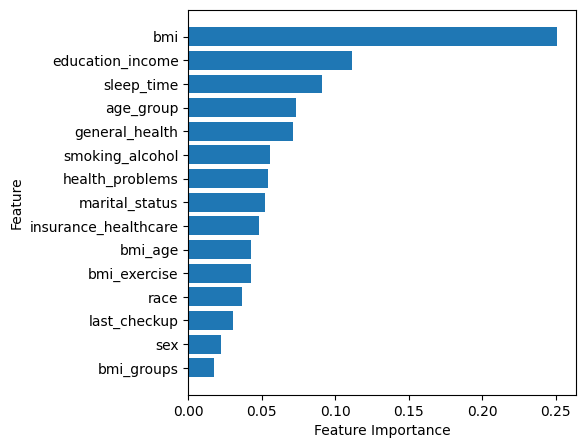

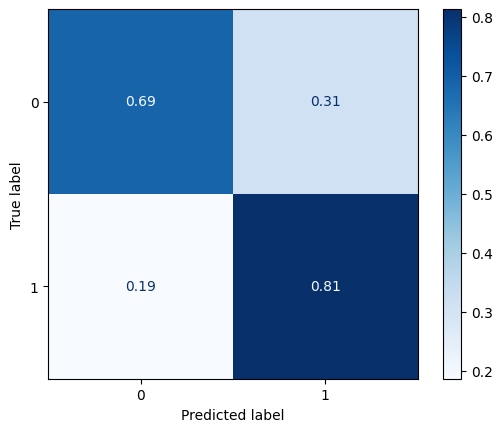

CPU times: user 1min 10s, sys: 876 ms, total: 1min 11s
Wall time: 57.7 s


In [94]:
%%time
ex3 = BalancedRandomForestModel(data)
ex3.model_pipeline(report=True, fi=True, cm=True)